<a href="https://colab.research.google.com/github/LxMera/Deep-Learning---denoising-rs-fMRI/blob/master/Permutation_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import os.path as path
if path.exists('Data'):   
    print ('The folder already exists')
else:
    !wget -nc https://www.dropbox.com/s/ufwmggstfj0xr8c/DatosXYZ.mat?dl=1
    !wget -nc https://www.dropbox.com/s/9vfa4ehuhu76jjl/Data.zip?dl=1
    !unzip Data.zip?dl=1 | awk 'BEGIN { ORS = "" } { print "|" }'
    !rm -r Data.zip?dl=1
    !mv DatosXYZ.mat?dl=1 Data/DatosXYZ.mat

The folder already exists


In [0]:
import numpy as np
import scipy.io

In [13]:
mat = scipy.io.loadmat('Data/DatosXYZ.mat')
etique = scipy.io.loadmat('Data/LabelFix.mat')
Datos=mat['Datos_C']
Etiq=np.transpose(etique['series'])[:,0]

print (np.shape(Datos))
print (np.shape(Etiq))

(22877, 27)
(22877,)


In [0]:
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')
from IPython.display import clear_output

### Training and test data

In [15]:
por=int(np.shape(Datos)[0]*0.8)

X_test=Datos[por:]
X_train=Datos[:por]

y_test=Etiq[por:]
y_train=Etiq[:por]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(18301, 27)
(18301,)
(4576, 27)
(4576,)


[ 4.45207214e-02  5.70885374e-02  6.29922245e-02  7.46339865e-02
  6.64547334e-02  2.03378205e-01  8.27433966e-02  3.56492457e-02
  6.33084193e-02  3.03898605e+00  4.74240573e-12  1.75981282e-02
 -1.37345068e+03  9.23868303e+00  3.97315410e+00  5.46848955e+00
  9.59243342e-01  2.70574574e-01  2.30887277e-01  1.43240533e+03
  6.26133380e-02  1.39508929e-03  3.87572462e+02  1.74653874e+02
  9.18976030e+01  0.00000000e+00  4.87198828e-02]


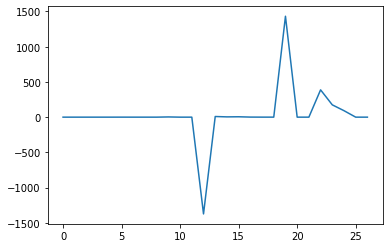

In [16]:
ind = np.random.permutation(X_train.shape[0])
plt.plot(X_train[ind[0],:]);
print(X_train[ind[0]])

### Standardization

In [17]:
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler

#Obtener las dimensiones de entrada de la red
input_dim = X_train.shape[1]

#Normalizar los datos de entrada.
scaler = StandardScaler()
X_trainNx = scaler.fit_transform(X_train)
X_testNx = scaler.fit_transform(X_test)
DatosN=scaler.fit_transform(Datos)

#Convertir las etiquetas a un arreglo de 10 salidas
y_trainOHE = np_utils.to_categorical(y_train)
nb_classes = y_trainOHE.shape[1]

print(y_trainOHE[ind[0],:])

[1. 0.]


[ 0.17579334  0.54509821 -0.2108817  -0.39372483 -0.14090884  0.03966406
 -0.46502129 -0.53141437 -0.71319653 -0.14306083  0.23645356  0.27637443
  0.62485811 -0.05896476 -0.26939183 -0.6678062   0.67405154  0.50226183
  0.40248844 -0.09143009 -0.09141715 -0.52374409  0.50226183  0.53729855
  0.56849434  0.          1.00602139]


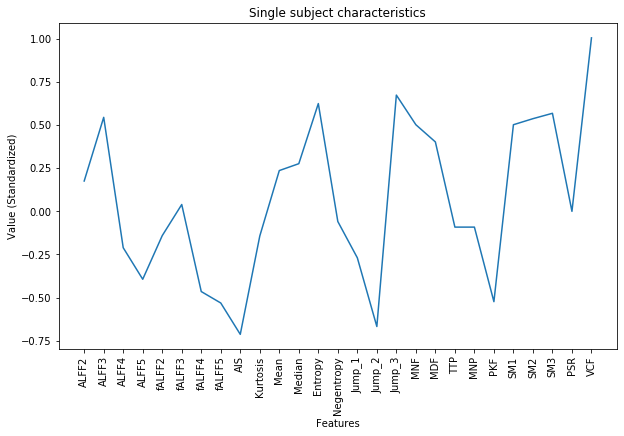

In [20]:
plt.figure(figsize=(10,6))
plt.plot(X_trainNx[ind[0],:]);
plt.title('Single subject characteristics')
plt.xlabel('Features')
pos=np.arange(27)
lab=['ALFF2','ALFF3','ALFF4','ALFF5','fALFF2','fALFF3','fALFF4','fALFF5','AIS','Kurtosis','Mean','Median','Entropy','Negentropy','Jump_1','Jump_2','Jump_3','MNF','MDF','TTP','MNP','PKF','SM1','SM2','SM3','PSR','VCF']
plt.xticks(pos,lab, rotation='vertical')
plt.ylabel('Value (Standardized)')
print(X_trainNx[ind[0]])

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Dropout
from sklearn.decomposition import FastICA, PCA

In [24]:
bat=500
reg=0.3
epo=100
pre1=[]
pre2=[]
pre3=[]
pre4=[]
  
for xy in range(27):
   
  co=xy-1
  print(lab[xy], 'Feature')
  if xy==0:
    X_trainN = X_trainNx.copy()
    X_testN = X_testNx.copy()
  else:
    ind=np.random.permutation(X_trainNx.shape[0])
    X_trainN = X_trainNx.copy()
    X_trainN[:,co]=X_trainN[ind,co]

    ind2=np.random.permutation(X_testNx.shape[0])
    X_testN = X_testNx.copy()
    X_testN[:,co]=X_testN[ind2,co]
  
  input_dim = X_testN.shape[1]
  
  
  #first model
  model = Sequential()
  model.add(Dense(13, input_dim=input_dim))
  model.add(Activation('tanh'))
  model.add(Dropout(reg))
  model.add(Dense(6))
  model.add(Activation('tanh'))
  model.add(Dropout(reg))
  model.add(Dense(nb_classes, activation='softmax'))
  
  #second model
  model2 = Sequential()
  model2.add(Dense(8, input_dim=input_dim))
  model2.add(Activation('tanh'))
  model2.add(Dropout(reg))
  model2.add(Dense(4))
  model2.add(Activation('tanh'))
  model2.add(Dropout(reg))
  model2.add(Dense(nb_classes, activation='softmax'))
  
  #Third model
  model3 = Sequential()
  model3.add(Dense(16, input_dim=input_dim))
  model3.add(Activation('tanh'))
  model3.add(Dropout(reg))
  model3.add(Dense(8))
  model3.add(Activation('tanh'))
  model3.add(Dropout(reg))
  model3.add(Dense(4))
  model3.add(Activation('tanh'))
  model3.add(Dropout(reg))
  model3.add(Dense(nb_classes, activation='softmax'))

  #Fourth model
  model4 = Sequential()
  model4.add(Dense(8, input_dim=input_dim))
  model4.add(Activation('tanh'))
  model4.add(Dropout(reg))
  model4.add(Dense(nb_classes, activation='softmax'))

  #Model parameters
  model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
  model2.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
  model3.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
  model4.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
  
  print("Training model 1...")
  history1x=model.fit(X_trainN, y_trainOHE, epochs=epo, batch_size=bat, validation_split=0.1, verbose=0)
  
  print("Training model 2...")
  history2x=model2.fit(X_trainN, y_trainOHE, epochs=epo, batch_size=bat, validation_split=0.1, verbose=0)
  
  print("Training model 3...")
  history3x=model3.fit(X_trainN, y_trainOHE, epochs=epo, batch_size=bat, validation_split=0.1, verbose=0)
  
  print("Training model 4...")
  history4x=model4.fit(X_trainN, y_trainOHE, epochs=epo, batch_size=bat, validation_split=0.1, verbose=0)
  
  
  #clear_output(wait=True)  
  preds = model.predict_classes(X_testN, verbose=0)
  Accuracy = np.mean(preds == y_test)
  pre1.append(Accuracy)  
  print('Accuracy = ', Accuracy*100, '%')
    
  preds2 = model2.predict_classes(X_testN, verbose=0)
  Accuracy2 = np.mean(preds2 == y_test)
  pre2.append(Accuracy2)
  print('Accuracy = ', Accuracy2*100, '%')  
  
  preds3 = model3.predict_classes(X_testN, verbose=0)
  Accuracy3 = np.mean(preds3 == y_test)
  pre3.append(Accuracy3)
  print('Accuracy = ', Accuracy3*100, '%')
  
  preds4 = model4.predict_classes(X_testN, verbose=0)
  Accuracy4 = np.mean(preds4 == y_test)
  pre4.append(Accuracy4)
  print('Accuracy = ', Accuracy4*100, '%')
  
  del model
  del model2
  del model3
  del model4
  #del pca

ALFF2 Feature
Training model 1...
Training model 2...
Training model 3...
Training model 4...
Accuracy =  96.98426573426573 %
Accuracy =  96.89685314685315 %
Accuracy =  96.74388111888112 %
Accuracy =  96.80944055944056 %
ALFF3 Feature
Training model 1...
Training model 2...
Training model 3...
Training model 4...
Accuracy =  96.70017482517483 %
Accuracy =  96.96241258741259 %
Accuracy =  96.70017482517483 %
Accuracy =  96.78758741258741 %
ALFF4 Feature
Training model 1...
Training model 2...
Training model 3...
Training model 4...
Accuracy =  97.00611888111888 %
Accuracy =  96.875 %
Accuracy =  96.5909090909091 %
Accuracy =  96.63461538461539 %
ALFF5 Feature
Training model 1...
Training model 2...
Training model 3...
Training model 4...
Accuracy =  96.56905594405595 %
Accuracy =  96.67832167832168 %
Accuracy =  96.61276223776224 %
Accuracy =  96.56905594405595 %
fALFF2 Feature
Training model 1...
Training model 2...
Training model 3...
Training model 4...
Accuracy =  96.875 %
Accuracy

IndexError: ignored

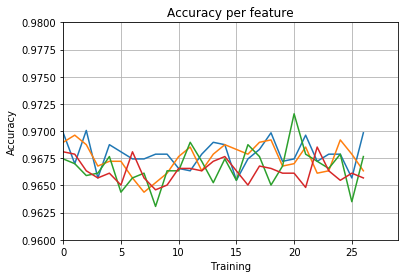

In [25]:
plt.plot(pre1)
plt.plot(pre2)
plt.plot(pre3)
plt.plot(pre4)
plt.ylim([0.96, 0.98])
plt.title('Accuracy per feature')
plt.xlim([0, 29])
plt.xlabel('Training')
plt.ylabel('Accuracy')
plt.grid()

In [26]:
print(np.mean(pre1)*100, np.max(pre1)*100)
print(np.mean(pre2)*100, np.max(pre2)*100)
print(np.mean(pre3)*100, np.max(pre3)*100)
print(np.mean(pre4)*100, np.max(pre4)*100)

96.78677803677803 97.00611888111888
96.74711862211862 96.96241258741259
96.67022792022793 97.1590909090909
96.63299663299662 96.85314685314685


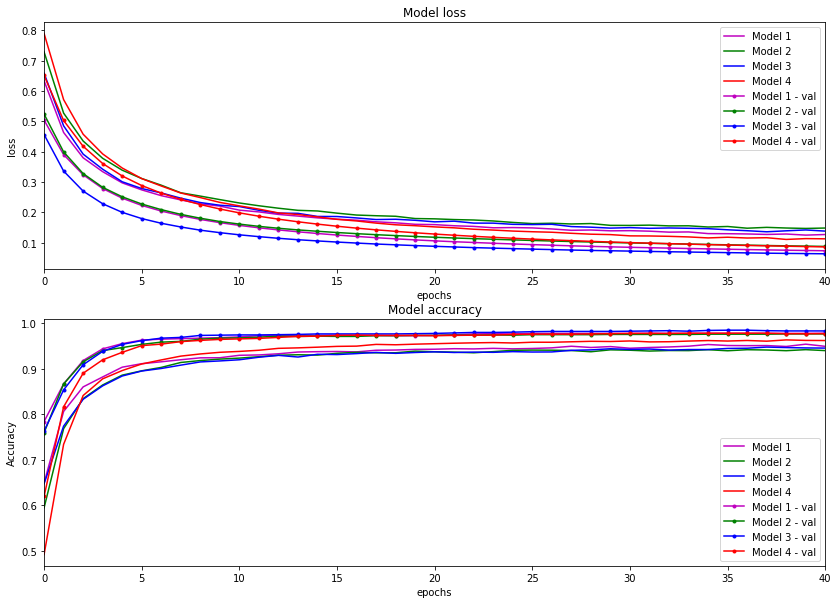

In [27]:
plt.figure(figsize=(14,10))
k=0
plt.subplot(2,1,1)
plt.plot(np.array(history1x.history['loss'])-k,'m')
plt.plot(np.array(history2x.history['loss'])-k,'g')
plt.plot(np.array(history3x.history['loss'])-k,'b')
plt.plot(np.array(history4x.history['loss'])-k,'r')

plt.plot(np.array(history1x.history['val_loss'])-k,'.-m')
plt.plot(np.array(history2x.history['val_loss'])-k,'.-g')
plt.plot(np.array(history3x.history['val_loss'])-k,'.-b')
plt.plot(np.array(history4x.history['val_loss'])-k,'.-r')

plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.xlim([0, 40])
plt.legend(['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 1 - val', 'Model 2 - val','Model 3 - val','Model 4 - val'], loc='upper rigth')

plt.subplot(2,1,2)
plt.plot(k+np.array(history1x.history['acc']),'m')
plt.plot(k+np.array(history2x.history['acc']),'g')
plt.plot(k+np.array(history3x.history['acc']),'b')
plt.plot(k+np.array(history4x.history['acc']),'r')

plt.plot(k+np.array(history1x.history['val_acc']),'.-m')
plt.plot(k+np.array(history2x.history['val_acc']),'.-g')
plt.plot(k+np.array(history3x.history['val_acc']),'.-b')
plt.plot(k+np.array(history4x.history['val_acc']),'.-r')

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.xlim([0, 40])
plt.legend(['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 1 - val', 'Model 2 - val','Model 3 - val','Model 4 - val'], loc='upper rigth')
plt.show()